# Mapping LA's Public Toilets
## Kevin Liu, Paola Tirado Escareno, Carolyn Chu
## UP 229: Urban Data Science, Spring 2022

**Introduction**

In the early months of the COVID-19 shutdown, restaurants, libraries, and gas stations closed their bathroom facilities due to the unknown nature of how the virus spread. For much of the general public, finding a restroom to use while out of their home was a novel problem borne by public health response. Though for unhoused people, this challenge precedes the pandemic, and the responses by many (most) city governments have been inadequate. The City of Los Angeles initially set up [363 hand washing stations and 182 portable toilets](https://www.latimes.com/opinion/story/2021-07-25/editorial-los-angeles-homeless-bathrooms) across the city. Since then, the city has struggled with maintenance and has faced backlash when trying to remove them (see [here](https://laist.com/news/housing-homelessness/la-city-council-to-consider-reinstating-porta-potties-for-unhoused-angelenos) or [here](https://www.lataco.com/porta-potty-homeless/)). Still, access to clean, accessible restrooms remains an ongoing and dire issue for unhoused people in our communities. In this research project, we examine the access and distribution to public restrooms by comparing their locations to the 2020 Homeless Count data from LA County.

Our research questions include, "What's the distribution of publicly available toilets in Los Angeles and how does this compare to the distribution of unhoused people in the county? Through spatial clustering, can we find patterns in this distribution? What kinds of correlation do we find between publicly available toilets and race/ethnicity of certain census tracts?" 

**Data Preparation**

Previous to this notebook, we compiled a dataset of publicly available toilets from a variety of data sources including LACAN, Los Angeles Recreation and Parks, and the LA and Los Angeles County Library systems. We also joined the Los Angeles County Homeless Count Data (2020) with 5-Year American Community Survey (ACS) population counts and census tract geometries (which we acquired from the census API and LA County Open Data Portal, respectively). We bring these datsets in at the beginning of this notebook.

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

### Import Data

In [3]:
#upload toilet data
toilets = gpd.read_file('alltoilets.geojson')
toilets.sample(10)

name  \
155                     Grand View and Pacific   
298                                       None   
76      Beacon Avenue (Between 7th and 8th St)   
362                                       None   
176               Coldwater Canyon / Riverside   
275            San Jullian between 5th and 6th   
339                                       None   
306                                       None   
210  North Highland Avenue & Willoughby Avenue   
10                                 Gladys Park   

                                      type                    branch_name  \
155              LAHSA Handwashing Station                           None   
298                      LA County Library                      View Park   
76               LAHSA Handwashing Station                           None   
362                        LA City Library                          Platt   
176              LAHSA Handwashing Station                           None   
275  Handwashing Stations not on LAHSA Map                           None   
339                        LA City Library                  Granada Hills   
306                        LA City Library  Westchester - Loyola Village    
210              LAHSA Handwashing Station                           None   
10                                LA Parks                           None   

                        geometry  
155  POINT (-118.43052 34.00394)  
298  POINT (-118.34100 33.99280)  
76   POINT (-118.27284 34.05364)  
362  POINT (-118.64180 34.18625)  
176  POINT (-118.41377 34.15690)  
275  POINT (-118.24547 34.04382)  
339  POINT (-118.49780 34.26430)  
306  POINT (-118.41800 33.95945)  
210  POINT (-118.33861 34.08710)  
10   POINT (-118.24190 34.04007)

The toilets dataset is a combination of all of the various LAHSA recorded handwashing stations, LACAN recorded handwashing stations, park bathrooms, and libraries. We code the data points by type, allowing us to later on map out the various types of hygiene stations all across the city and county.

In [4]:
#upload homeless data count
counts = gpd.read_file('homelesscount_tracts.geojson').to_crs('EPSG:4326')
counts.head()

short_geoid     shape_area    label   x_center    ct10   y_center  \
0       911001  4025735684.42  9110.01  6620403.0  911001  1998891.0   
1       980003  2078689856.02  9800.03  6575300.0  980003  2112006.0   
2       930301  11118018325.1  9303.01  6603027.0  930301  1932124.0   
3       573003  4824001.88224  5730.03  6500215.0  573003  1747305.0   
4       297602   6697030.7108  2976.02  6473372.0  297602  1719119.0   

       geoid10      shape_len  total_pop  homeless_count  \
0  06037911001  353933.808192     4087.0            30.0   
1  06037980003   273188.86321        0.0           925.0   
2  06037930301  628603.531323      869.0           928.0   
3  06037573003  9050.00845755     2016.0             2.0   
4  06037297602  12308.3153848     4005.0            64.0   

                                            geometry  
0  MULTIPOLYGON (((-117.66712 34.55801, -117.6671...  
1  MULTIPOLYGON (((-117.88061 34.76362, -117.8825...  
2  MULTIPOLYGON (((-117.65524 34.39722, -117.6551...  
3  MULTIPOLYGON (((-118.19923 33.79712, -118.1992...  
4  MULTIPOLYGON (((-118.28798 33.72258, -118.2879...

The homelesscount_tracts dataset is a joined json containing both the [2020 Economic Roundtable Homeless Count by Census Tract data](https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/), and the 2019 ACS 5-Year Estimate Total Population of LA County divided by census tract. The 2020 Homeless Count data utilizes the older census tracts from the 2019 ACS 5-year as opposed to the new 2020 tracts. So, we joined the 2020 Homeless Count data with the 2019 ACS 5-year data on the census tract.

In [6]:
#upload race data
raceGdf = gpd.read_file('race.geojson')
raceGdf.head()

short_geoid     shape_area    label   x_center    ct10   y_center  \
0       911001  4025735684.42  9110.01  6620403.0  911001  1998891.0   
1       980003  2078689856.02  9800.03  6575300.0  980003  2112006.0   
2       930301  11118018325.1  9303.01  6603027.0  930301  1932124.0   
3       573003  4824001.88224  5730.03  6500215.0  573003  1747305.0   
4       297602   6697030.7108  2976.02  6473372.0  297602  1719119.0   

       geoid10      shape_len   total  Non Hispanic  ...  \
0  06037911001  353933.808192  3926.0        2245.0  ...   
1  06037980003   273188.86321     0.0           0.0  ...   
2  06037930301  628603.531323   796.0         611.0  ...   
3  06037573003  9050.00845755  1843.0        1005.0  ...   
4  06037297602  12308.3153848  3687.0        2260.0  ...   

   Percent Non Hispanic White  Percent Non Hispanic Black  \
0                   48.726439                    4.457463   
1                         NaN                         NaN   
2                   56.030151                    8.165829   
3                   24.959305                    5.425936   
4                   44.290751                    3.390290   

   Percent Non Hispanic American Indian and Alaska Native  \
0                                           0.000000        
1                                                NaN        
2                                           0.000000        
3                                           0.596853        
4                                           0.244101        

   Percent Non Hispanic Asian  \
0                    1.299032   
1                         NaN   
2                    1.758794   
3                   20.781335   
4                    8.950366   

   Percent Non Hispanic Native Hawaiian and Other Pacific Islander  \
0                                           0.000000                 
1                                                NaN                 
2                                           0.753769                 
3                                           0.000000                 
4                                           0.542446                 

   Percent Non Hispanic Some other race  Percent Hispanic Latino  \
0                              0.000000                42.817117   
1                                   NaN                      NaN   
2                              0.000000                23.241206   
3                              0.379816                45.469343   
4                              0.054245                38.703553   

   Percent Non white  Non white  \
0          48.573612     1907.0   
1                NaN        0.0   
2          33.919598      270.0   
3          72.653283     1339.0   
4          51.885001     1913.0   

                                            geometry  
0  MULTIPOLYGON (((-117.66712 34.55801, -117.6671...  
1  MULTIPOLYGON (((-117.88061 34.76362, -117.8825...  
2  MULTIPOLYGON (((-117.65524 34.39722, -117.6551...  
3  MULTIPOLYGON (((-118.19923 33.79712, -118.1992...  
4  MULTIPOLYGON (((-118.28798 33.72258, -118.2879...  

[5 rows x 28 columns]

The raceGdf dataset is 2019 ACS data containing multiple variables regarding race. Each ethnicity's percentage of the total population was calculated and put into new columns, and then joined with the 2010 Census tracts for geometry data. 

In [8]:
#upload income data

incomeGdf = gpd.read_file('income.geojson')
incomeGdf.head()

short_geoid     shape_area    label   x_center    ct10   y_center  \
0       911001  4025735684.42  9110.01  6620403.0  911001  1998891.0   
1       980003  2078689856.02  9800.03  6575300.0  980003  2112006.0   
2       930301  11118018325.1  9303.01  6603027.0  930301  1932124.0   
3       573003  4824001.88224  5730.03  6500215.0  573003  1747305.0   
4       297602   6697030.7108  2976.02  6473372.0  297602  1719119.0   

       geoid10      shape_len  median_income  \
0  06037911001  353933.808192        28801.0   
1  06037980003   273188.86321            0.0   
2  06037930301  628603.531323        32700.0   
3  06037573003  9050.00845755        30373.0   
4  06037297602  12308.3153848        40094.0   

                                            geometry  
0  MULTIPOLYGON (((-117.66712 34.55801, -117.6671...  
1  MULTIPOLYGON (((-117.88061 34.76362, -117.8825...  
2  MULTIPOLYGON (((-117.65524 34.39722, -117.6551...  
3  MULTIPOLYGON (((-118.19923 33.79712, -118.1992...  
4  MULTIPOLYGON (((-118.28798 33.72258, -118.2879...

The incomeGdf dataset is 2019 ACS estimate of median household income data. Null values and 0's have been dropped, and then joined with 2010 Census tracts for geometry data.

### Demographics of LA County and Hygiene Station Availability

Let's take a look at our toilets dataset overlayed across some demographic data around Los Angeles County. First we'll take a look at race, specifically % BIPOC population.

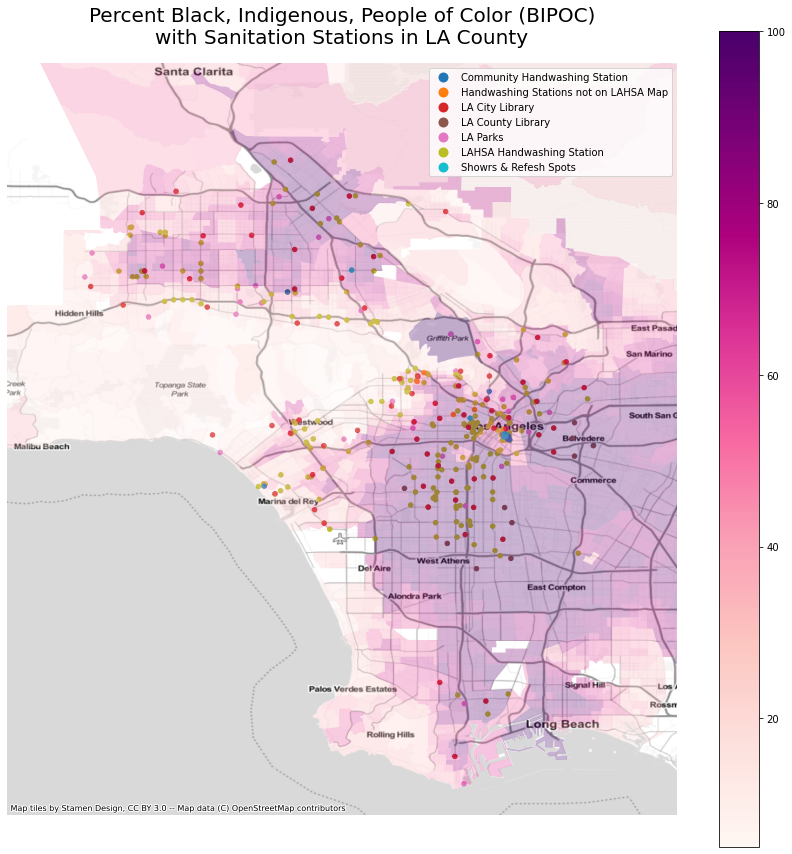

In [9]:
#LA county wide map

f, ax = plt.subplots(figsize=(15,15))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

raceGdf.plot('Percent Non white', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical'}, 
            alpha=0.3, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])

ax.set_title('Percent Black, Indigenous, People of Color (BIPOC)\n' + 'with Sanitation Stations in LA County', 
             fontsize=20, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

It's no surprise that most of the City of LA is majority BIPOC, and the hygiene station data doesn't seem to have any meaningful relationship to % BIPOC population. While most hygiene station data points are in majority BIPOC tracts, some areas like the southern part of the Valley, Westwood, and Venice are all majority white areas that still have a decent amount of hygiene stations. It is interesting to see how much whiter the westside of LA is, and also the outskirts of the Valley.

Second, let's take a look at median household income data.

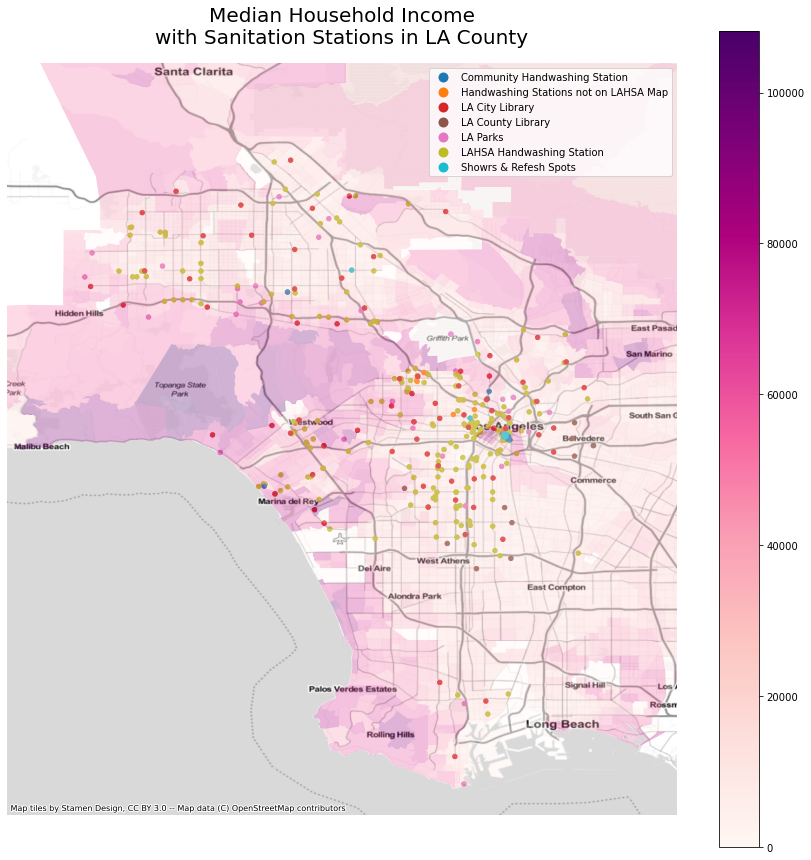

In [10]:
f, ax = plt.subplots(figsize=(15,15))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

incomeGdf.plot('median_income', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical'}, 
            alpha=0.3, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])

ax.set_title('Median Household Income\n' + 'with Sanitation Stations in LA County', fontsize=20, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

The immediate relationship that stands out is that some of the extremely wealthy communities do not have public hygiene stations available, like Rancho Palos Verdes, the tract immediately southwest of Griffith Park, all of the Santa Monica Mountains (Topanga, Bel Air, etc), Redondo/Hermosa Beach, and the Rose Bowl Area of Pasadena. There's also a noticeable gap of hygiene station availability for lower income tracts between West Athens and Long Beach.

### Spatial Join of Toilets and Point in Time Count

To get a sense of how many toilets are available to each houseless person within a given census tract, we spatially join toilets and homelesscount_tracts, count the number of toilets within each census tract, and divide the houseless population in the tract by the number of toilets. This section of our notebook is mainly cleaning, wrangling and calculating data.

In [11]:
joinedGdf = gpd.sjoin(counts, toilets, how='left', predicate = 'intersects')
joinedGdf.head()

short_geoid     shape_area    label   x_center    ct10   y_center  \
0       911001  4025735684.42  9110.01  6620403.0  911001  1998891.0   
1       980003  2078689856.02  9800.03  6575300.0  980003  2112006.0   
2       930301  11118018325.1  9303.01  6603027.0  930301  1932124.0   
3       573003  4824001.88224  5730.03  6500215.0  573003  1747305.0   
4       297602   6697030.7108  2976.02  6473372.0  297602  1719119.0   

       geoid10      shape_len  total_pop  homeless_count  \
0  06037911001  353933.808192     4087.0            30.0   
1  06037980003   273188.86321        0.0           925.0   
2  06037930301  628603.531323      869.0           928.0   
3  06037573003  9050.00845755     2016.0             2.0   
4  06037297602  12308.3153848     4005.0            64.0   

                                            geometry  index_right name type  \
0  MULTIPOLYGON (((-117.66712 34.55801, -117.6671...          NaN  NaN  NaN   
1  MULTIPOLYGON (((-117.88061 34.76362, -117.8825...          NaN  NaN  NaN   
2  MULTIPOLYGON (((-117.65524 34.39722, -117.6551...          NaN  NaN  NaN   
3  MULTIPOLYGON (((-118.19923 33.79712, -118.1992...          NaN  NaN  NaN   
4  MULTIPOLYGON (((-118.28798 33.72258, -118.2879...          NaN  NaN  NaN   

  branch_name  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [12]:
#check whether lengths are ok - looks reasonable
print('counts length: {}'.format(len(counts)))
print('toilets length: {}'.format(len(toilets)))
print('joinedGdf length: {}'.format(len(joinedGdf)))


counts length: 2345
toilets length: 374
joinedGdf length: 2469


In [13]:
#right join to the toilets, so drops all census tracts w/o toilets
joinedGdf2 = gpd.sjoin(counts, toilets, how='right', predicate='intersects')

In [14]:
#check that it looks correct
#joinedGdf2.head()

In [15]:
#bring back the original joinedGdf
#set index in preparation of joining n_TOILETS
joinedGdf.set_index('short_geoid', inplace=True)

In [16]:
#count the number of toilets per census tract
#creates a series
n_toilets = joinedGdf2.groupby('short_geoid').size()

#convert the series into a df
n_TOILETS=pd.DataFrame(n_toilets)

In [17]:
#rename the column to something that makes more sense
n_TOILETS.columns = ['number_toilets']

In [18]:
#join
joinedGdf3=joinedGdf.join(n_TOILETS)

In [19]:
#fill all NaN's with zero
joinedGdf3['number_toilets'] = joinedGdf3['number_toilets'].fillna(0)

In [20]:
#joinedGdf3.head()

In [21]:
#calculate a ratio of # of people per public toilet/handwashing station
joinedGdf3['toilet_ratio'] = joinedGdf3['homeless_count']/joinedGdf3['number_toilets']
joinedGdf3.head()

shape_area    label   x_center    ct10   y_center  \
short_geoid                                                         
101110       12295652.6944  1011.10  6473137.0  101110  1916938.0   
101122       28457712.2343  1011.22  6474004.0  101122  1919937.0   
101210       7003370.52469  1012.10  6473812.0  101210  1914571.0   
101220       7522986.29954  1012.20  6476560.0  101220  1914066.0   
101300       27772933.9487  1013.00  6479771.0  101300  1913027.0   

                 geoid10      shape_len  total_pop  homeless_count  \
short_geoid                                                          
101110       06037101110  15083.8543322     4824.0          1463.0   
101122       06037101122  31671.4558884     3291.0           671.0   
101210       06037101210    12066.77064     5882.0          1445.0   
101220       06037101220  12697.6262999     2902.0          1703.0   
101300       06037101300  29383.7012162     4410.0          1578.0   

                                                      geometry  index_right  \
short_geoid                                                                   
101110       MULTIPOLYGON (((-118.29792 34.26322, -118.2969...        369.0   
101122       MULTIPOLYGON (((-118.27742 34.25990, -118.2774...          NaN   
101210       MULTIPOLYGON (((-118.28592 34.25589, -118.2859...          NaN   
101220       MULTIPOLYGON (((-118.27817 34.25577, -118.2782...          NaN   
101300       MULTIPOLYGON (((-118.26526 34.25238, -118.2653...          NaN   

             name             type        branch_name  number_toilets  \
short_geoid                                                             
101110       None  LA City Library  Sunland - Tujunga             1.0   
101122        NaN              NaN                NaN             0.0   
101210        NaN              NaN                NaN             0.0   
101220        NaN              NaN                NaN             0.0   
101300        NaN              NaN                NaN             0.0   

             toilet_ratio  
short_geoid                
101110             1463.0  
101122                inf  
101210                inf  
101220                inf  
101300                inf

In [22]:
# Replacing all inf values in the dataframe with zero

import numpy as np
joinedGdf3 = joinedGdf3.replace([np.inf, -np.inf], 0)

### Exploring the toilet ratio

We just cleaned and calculated our data. Next, we'll examine our data by sorting and mapping.

In [23]:
#sort by census tracts with highest number of toilets
toilets_descending = joinedGdf3.sort_values(by='number_toilets',ascending = False)
toilets_descending.head(5)

shape_area    label   x_center    ct10   y_center  \
short_geoid                                                         
206300       6637586.94543  2063.00  6487985.0  206300  1837432.0   
206300       6637586.94543  2063.00  6487985.0  206300  1837432.0   
206300       6637586.94543  2063.00  6487985.0  206300  1837432.0   
206300       6637586.94543  2063.00  6487985.0  206300  1837432.0   
206300       6637586.94543  2063.00  6487985.0  206300  1837432.0   

                 geoid10      shape_len  total_pop  homeless_count  \
short_geoid                                                          
206300       06037206300  13167.1657338     5514.0           403.0   
206300       06037206300  13167.1657338     5514.0           403.0   
206300       06037206300  13167.1657338     5514.0           403.0   
206300       06037206300  13167.1657338     5514.0           403.0   
206300       06037206300  13167.1657338     5514.0           403.0   

                                                      geometry  index_right  \
short_geoid                                                                   
206300       MULTIPOLYGON (((-118.23811 34.04327, -118.2382...        267.0   
206300       MULTIPOLYGON (((-118.23811 34.04327, -118.2382...         58.0   
206300       MULTIPOLYGON (((-118.23811 34.04327, -118.2382...         38.0   
206300       MULTIPOLYGON (((-118.23811 34.04327, -118.2382...        275.0   
206300       MULTIPOLYGON (((-118.23811 34.04327, -118.2382...         36.0   

                                         name  \
short_geoid                                     
206300             Crushow (5th and Stanford)   
206300                      501 San Julian St   
206300                        5th / San Pedro   
206300        San Jullian between 5th and 6th   
206300       East 5th Street & Crocker Street   

                                              type branch_name  \
short_geoid                                                      
206300               Community Handwashing Station        None   
206300                   LAHSA Handwashing Station        None   
206300                   LAHSA Handwashing Station        None   
206300       Handwashing Stations not on LAHSA Map        None   
206300                   LAHSA Handwashing Station        None   

             number_toilets  toilet_ratio  
short_geoid                                
206300                 24.0     16.791667  
206300                 24.0     16.791667  
206300                 24.0     16.791667  
206300                 24.0     16.791667  
206300                 24.0     16.791667

In the lines of code and output above, we see that areas around Skid Row have highest concentrations of toilets, showers, and refresh spots. **In the Skid Row area, there are approximately 17 people to 1 restroom.** (See toilet_ratio column.)

In [24]:
# which tracts had the highest ratio of houseless people per toilet
ratio_descending = joinedGdf3.sort_values(by='toilet_ratio',ascending = False)
ratio_descending.head(3) #chose 3 to shorten the length of this notebook


shape_area    label   x_center    ct10   y_center  \
short_geoid                                                         
181400       9463037.10995  1814.00  6498460.0  181400  1872203.0   
188100       22871279.8937  1881.00  6479617.0  188100  1872185.0   
218110       6443242.09396  2181.10  6462438.0  218110  1838675.0   

                 geoid10      shape_len  total_pop  homeless_count  \
short_geoid                                                          
181400       06037181400  14429.0461216     4619.0          2331.0   
188100       06037188100  26027.2297326     3761.0          2258.0   
218110       06037218110  12758.8563101     3476.0          2256.0   

                                                      geometry  index_right  \
short_geoid                                                                   
181400       MULTIPOLYGON (((-118.20150 34.13956, -118.2015...        331.0   
188100       MULTIPOLYGON (((-118.27556 34.15317, -118.2755...         20.0   
218110       MULTIPOLYGON (((-118.32670 34.04782, -118.3255...        303.0   

                           name             type        branch_name  \
short_geoid                                                           
181400                     None  LA City Library        Eagle Rock    
188100       North Atwater Park         LA Parks               None   
218110                     None  LA City Library  Washington Irving   

             number_toilets  toilet_ratio  
short_geoid                                
181400                  1.0        2331.0  
188100                  1.0        2258.0  
218110                  1.0        2256.0

In [25]:
ratio_ascending = joinedGdf3.sort_values(by='toilet_ratio',ascending = True)
ratio_ascending.head(3) #chose 3 to shorten the length of this notebook


shape_area    label   x_center    ct10   y_center  \
short_geoid                                                         
403000       26031458.9794  4030.00  6635225.0  403000  1836115.0   
503502       13395511.3668  5035.02  6560697.0  503502  1797646.0   
503601       15017905.8961  5036.01  6558278.0  503601  1794182.0   

                 geoid10      shape_len  total_pop  homeless_count  \
short_geoid                                                          
403000       06037403000  25904.9008688     7118.0           895.0   
503502       06037503502  17898.4837216     4154.0          1773.0   
503601       06037503601  16783.5134451     4245.0          1774.0   

                                                      geometry  index_right  \
short_geoid                                                                   
403000       MULTIPOLYGON (((-117.74965 34.04421, -117.7495...          NaN   
503502       MULTIPOLYGON (((-117.99310 33.93352, -117.9930...          NaN   
503601       MULTIPOLYGON (((-118.00351 33.92308, -118.0034...          NaN   

            name type branch_name  number_toilets  toilet_ratio  
short_geoid                                                      
403000       NaN  NaN         NaN             0.0           0.0  
503502       NaN  NaN         NaN             0.0           0.0  
503601       NaN  NaN         NaN             0.0           0.0

Most census tracts have 0-1 toilet in the entire tract. Therefore, we're seeing ratios of **0 toilets per 7,000+ unhoused people, or 2331 unhoused people to 1 toilet (in Eagle Rock, for example)**. However, we can likely assume that unhoused people in these tracts are likely using some publicly available restrooms elsewhere (in addition to using public streets, alleys, or other public spaces as restrooms). This illustrates one of our study's key limitations: our dataset of publicly available restrooms is not comprehensive.

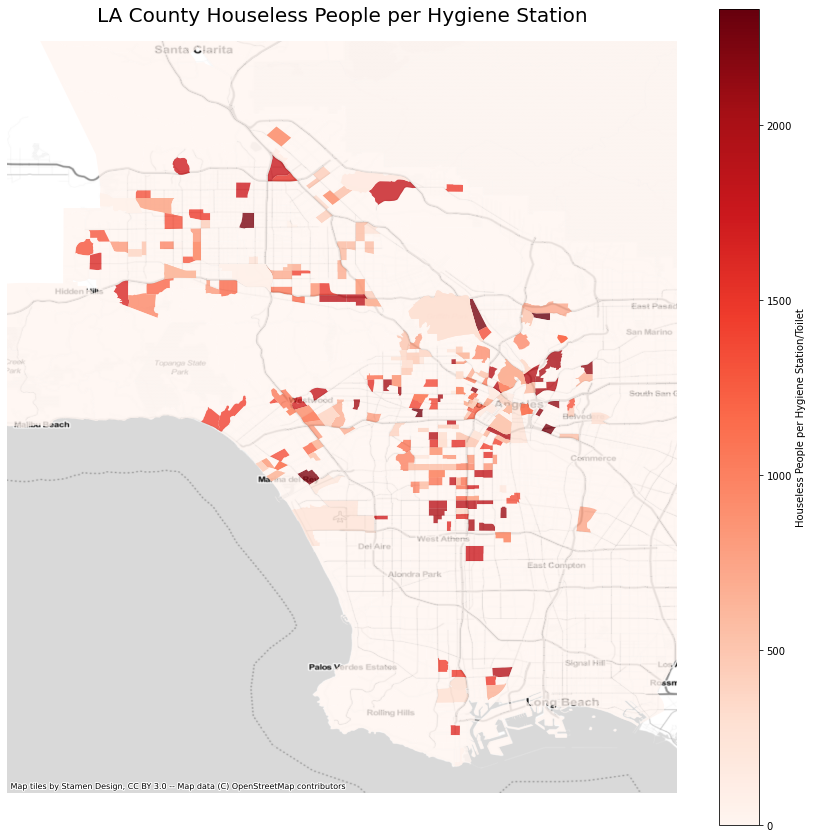

In [26]:
#LA county wide map

f, ax = plt.subplots(figsize=(15,15))

joinedGdf3.plot('toilet_ratio', 
            ax=ax, 
            cmap='Reds', 
            legend=True, 
            legend_kwds={'orientation': 'vertical', 'label':'Houseless People per Hygiene Station/Toilet'}, 
            alpha=0.8, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])
ax.set_title('LA County Houseless People per Hygiene Station', fontsize=20, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

We see that areas that we would assume to be relatively well covered in terms of houseless services (Skid Row/Downtown, parts of the Valley) do seem to have lower overall people per hygiene station. Similarly, some of the more affluent areas such as Marina Del Rey, northern parts of the Valley, and Eagle Rock/Glendale seem to have higher people per hygiene station. But areas of South LA and NELA/East LA do look to be struggling with higher people per hygiene station.

### Exploring the datasets spatially

We also wanted to overlay the toilets data with the number of houseless individuals per census tract, with the aim at identifying certain tracts that have high houseless populations and a lack of hygiene stations available.

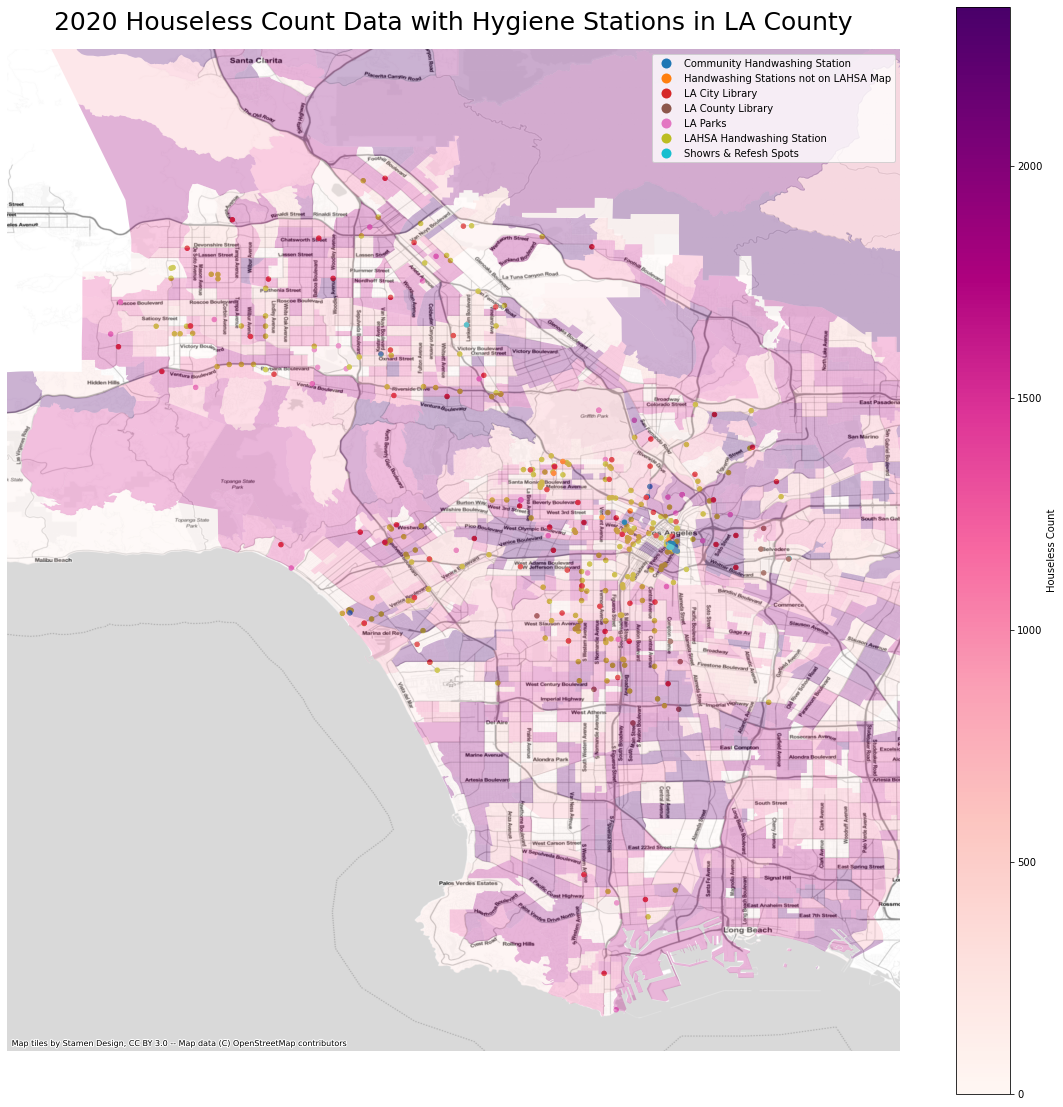

In [27]:
#LA county wide map
f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation':'vertical', 'label':'Houseless Count'}, 
            alpha=0.3, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])

ax.set_title('2020 Houseless Count Data with Hygiene Stations in LA County', fontsize=25, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite, zoom=12)

plt.show()

First, we take a wider look at all of the parts of LA County where our data is represented. We leave out the Antelope Valley and Catalina because we don't have any hygiene station data from those areas. <br>
<br>
Just from this zoomed out view of the datasets, we see that the tracts with the largest houseless populations are sprinkled throughout the County without any readily identifiable trends at first glance. We see some tracts with high houseless populations in the San Fernando Valley, particularly in the southern side up against the Studio City area. It seems that the most high concentration tracts occur throughout Central Los Angeles, Downtown LA, East LA, and the Mid City area, but also some parts of Culver-West and Westchester.<br>
<br>
To get an idea of how the toilets dataset looks countywide, we also conduct some spatial clustering below.

[]

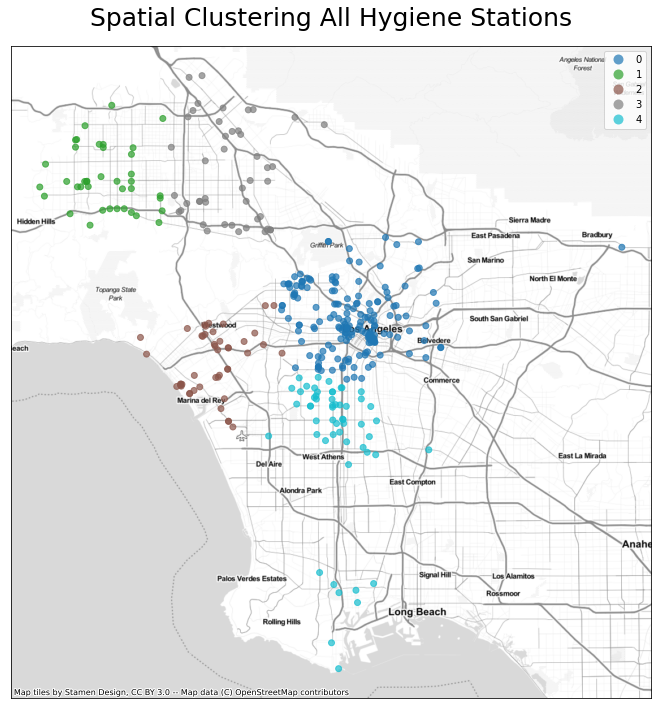

In [28]:
# Splitting out our geoemtry column into separate lat long columns
gdf = toilets
gdf['lon'] = gdf.geometry.apply(lambda p: p.x)
gdf['lat'] = gdf.geometry.apply(lambda p: p.y)

# Running kmeans to create the cluster_id column based on the lat long
# Selecting 5 clusters to begin with, knowing that we have around 5-6 different concentrations of data

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1).fit(gdf[['lat','lon']])
gdf['cluster_id'] = kmeans.labels_

# Plotting

fig, ax = plt.subplots(figsize=(12,12))

gdf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, legend=True, 
                                   ax=ax, alpha=0.7)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Spatial Clustering All Hygiene Stations', fontsize=25, pad=20)                           

ax.set_xticks([])
ax.set_yticks([])

It looks like the clusters breakdown as:

0 - Central & East LA <br>
1 - West San Fernando Valley <br>
2 - West LA <br>
3 - East San Fernando Valley <br>
4 - South LA and South Bay
<br>


Seeing as we have some clear clusters around Central LA, East LA and the San Fernando Valley, let's take a closer look at each of these neighborhoods

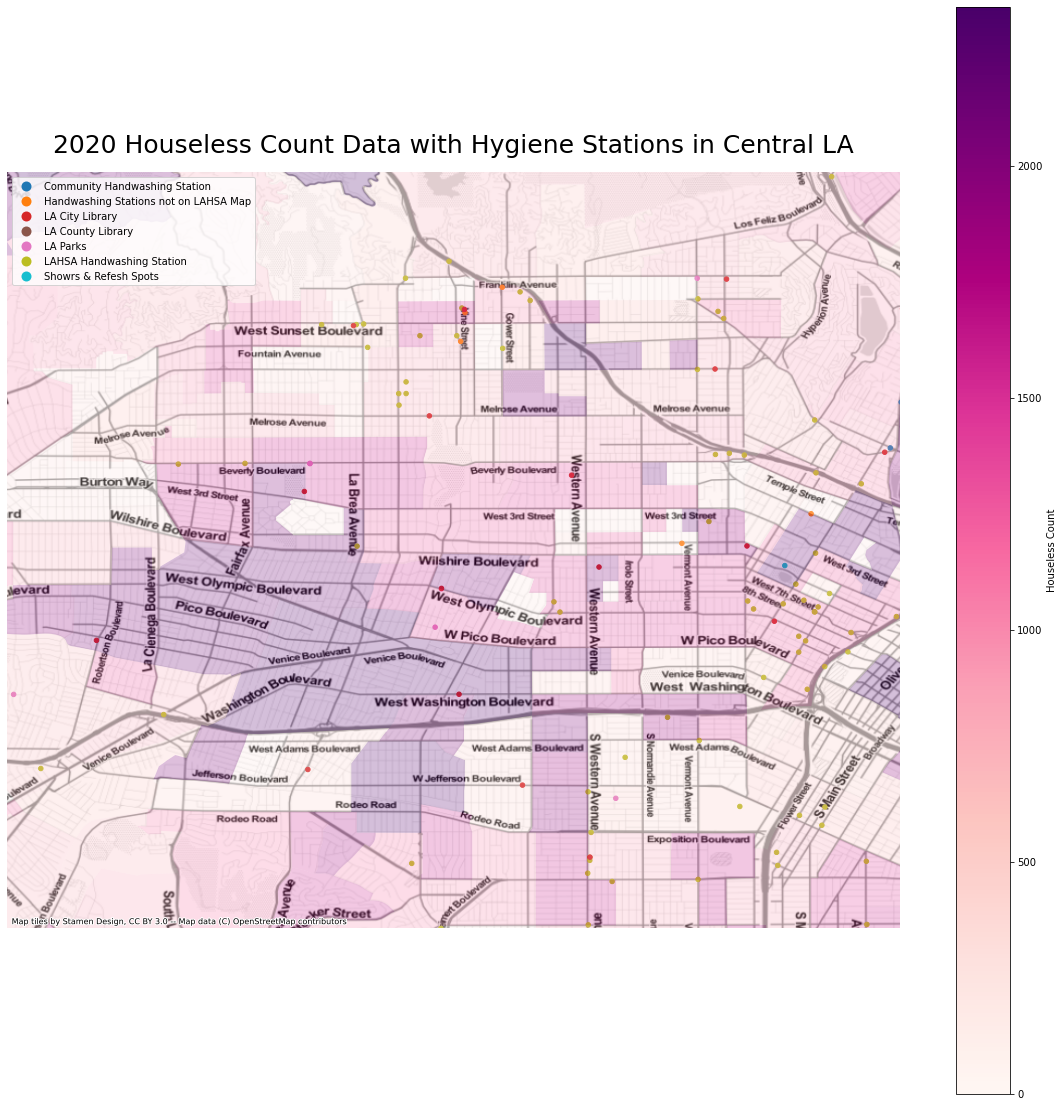

In [29]:
# Central LA specific map

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical', 'label':'Houseless Count'}, 
            alpha=0.25, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.40, -118.26]) 
ax.set_ylim([34.003307, 34.121767])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in Central LA', fontsize=25, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()


Acknowledging that we do not have information about every bathroom available in LA, there is a noticeable gap in hygiene station availability in the Mid City area. Notably, the LAHSA Handwashing Stations (light green dots) almost seem to avoid that area entirely, but are in areas directly adjacent to Mid City like Koreatown or Culver City. In general, we see a decline of hygiene station density as we move west from Downtown, with zero community handwashing stations (blue dots) west of Westlake and MacArthur Park.


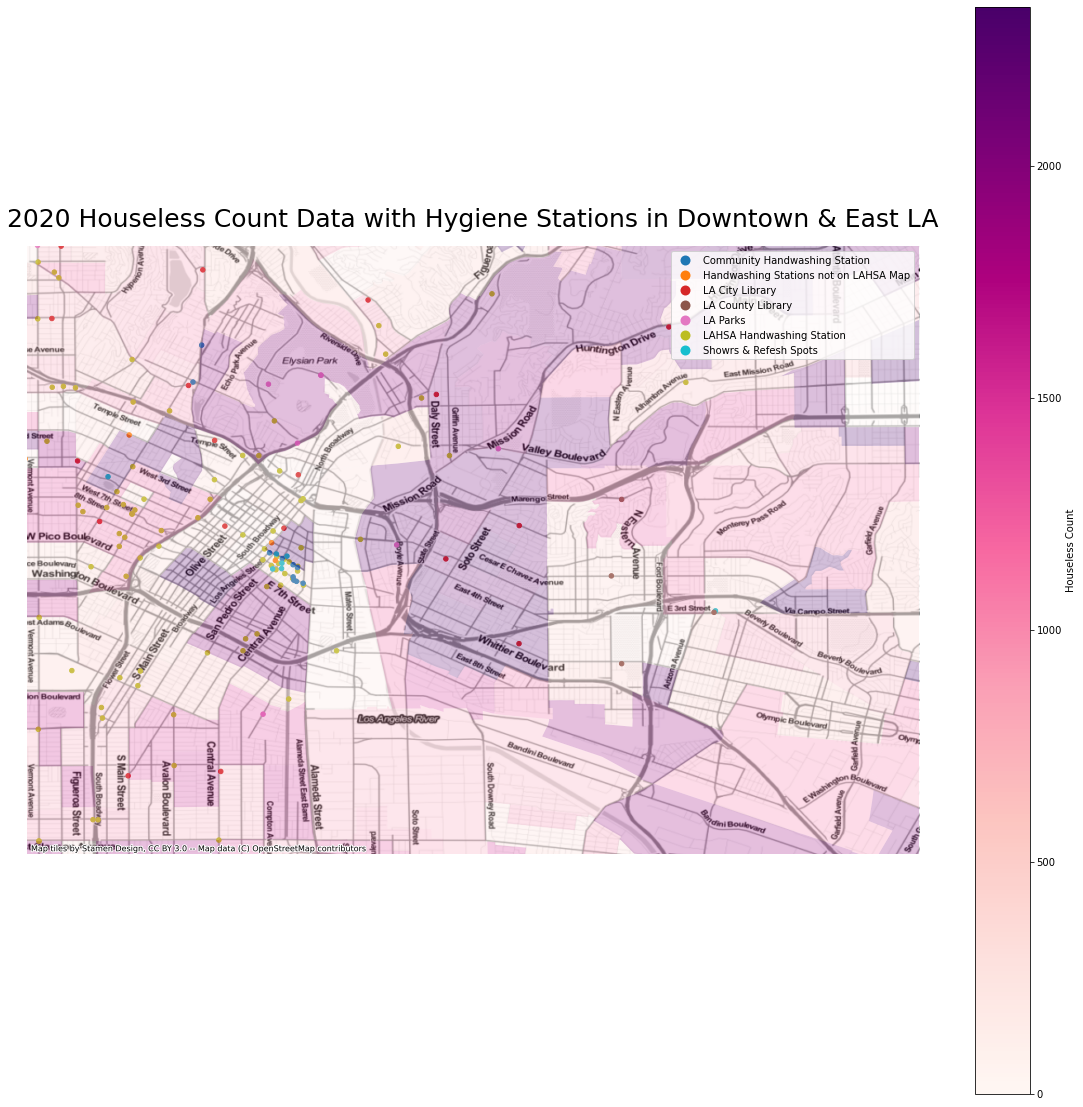

In [30]:
# East LA specific map

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical', 'label':'Houseless Count'}, 
            alpha=0.25)

ax.axis('off')
ax.set_xlim([-118.293942, -118.12]) 
ax.set_ylim([33.986563, 34.105046])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in Downtown & East LA', fontsize=25, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

In Boyle Heights, we see a large houseless population with no LAHSA handwashing stations, no community stations, and no Shower or Refresh spots. The only data points we have for publicly available restrooms are from the LA City Library and a park. Downtown has the largest concentration of hygiene stations out of all of the neighborhoods in our dataset, and the density of hygiene stations dissipates as we move out of Downtown. 
<br>
<br>
The Westlake and MacArthur Park area has an especially large concentration of LAHSA Handwashing Stations, but there is a noticeable deadzone in the Historic Filipinotown area where there is a larger concentration of unhoused folks.
<br>
<br>
Interestingly, the data Downtown seems to suggest that hygiene stations are placed just outside of where most houseless people were counted. This can be chalked up to the point data from the houseless dataset being right on the border between census tracts;.

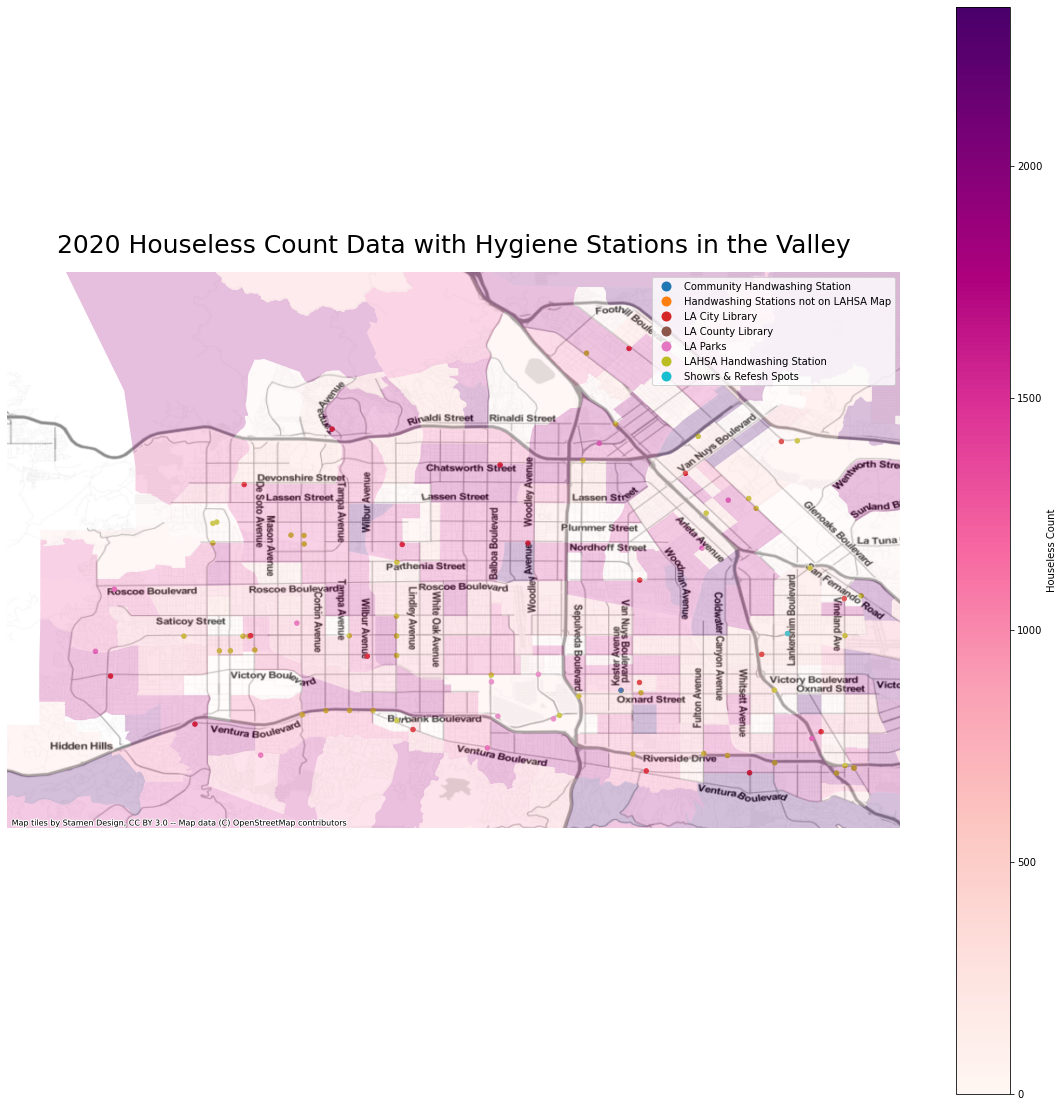

In [31]:
# Valley

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical', 'label':'Houseless Count'}, 
            alpha=0.25, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.68, -118.35]) 
ax.set_ylim([34.13, 34.335567])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in the Valley', fontsize=25, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

In the Valley, LAHSA Handwashing stations seem to be better placed in response to higher houseless populations. However, there is a noticeable disparity between houseless count and hygiene station availability in the Granada Hills South area. 
<br>
<br>
We also see LA City Library branches being positioned in tracts with large houseless populations, but because of the way that libraries are often policed, we remain doubtful that houselss folks are permitted to freely utilize libraries as hygiene stations.

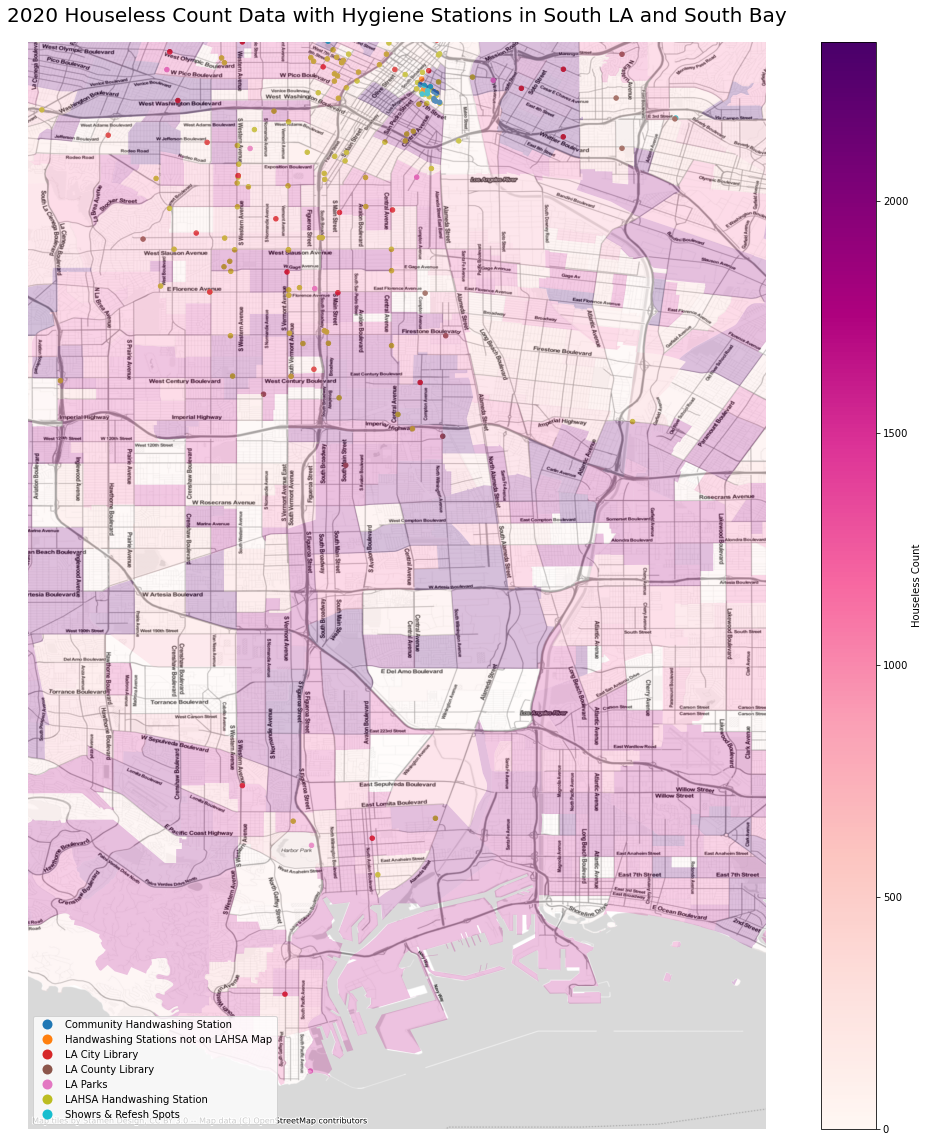

In [32]:
# South LA

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='RdPu', 
            legend=True, 
            legend_kwds={'orientation': 'vertical', 'label':'Houseless Count'}, 
            alpha=0.25, 
            label='Count')

ax.axis('off')
ax.set_xlim([-118.38, -118.12910]) 
ax.set_ylim([33.69, 34.06])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in South LA and South Bay', fontsize=20, pad=20)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite, zoom=13)

plt.show()

South LA and South Park are pretty well covered by LAHSA, but that stops as we move south of the I-105 Freeway, where there are quite high concentrations of houseless populations who are relying on just a couple of LA County Library branches.
<br>
<br>
South Alameda St also seems to be a stark divider for houseless counts. Tracts west of South Alameda St show higher concentrations of houseless folks, and those east of Alameda are relatively less dense. The number of hygiene stations available reflects this breakdown, as LAHSA Handwashing Stations go from nearly 0 east of Alameda to quite numerous west of Alameda.

## Takeaways & Concluding Thoughts

Because our list of hygiene stations is by no means a complete list of all publicy available stations in LA County, it is difficult to draw any sweeping conclusions about the availability of hygiene stations for our houseless neighbors. The houseless count data also has its own flaws, but for the most part seems to reflect reality.
<br>
<br>
Utilizing the data we do have, it does seem that there are a few specific areas of the city and the county where more LAHSA handwashing stations can be made available. Some of the most egregious people per hygiene station numbers occur in Mid City, East LA, and South LA. Additionally, our dataset shows that LA Parks can be a particularly valuable source of hygiene stations in areas that are largely without options. Unfortunately, access to Parks, as well as City and County Libraries, is restricted by policing, and as a result, an untrustworthy source of hygiene for houseless folks.
<br>
<br>
Both hygiene stations and houseless folks are inherently difficult to produce data about, but hopefully our work here shows some of the ways that we can continue to work towards understanding more about houseless communities' access to basic hygiene. Readily available online maps currently do not display this variety of hygiene station types. We are building upon the work of LACAN, who built upon the LAHSA stations list, and we hope that this type of mapping will continue. Access to basic hygiene is a human right, and hopefully through mapping we can keep authorities like LAHSA and the City of LA accountable to where hygiene services are needed the most.